# Define the ontology
The model for the knowledge graph is a combination between these three ontologies:
- nutsdef: The model for the nuts regions as defined by [Eurostat](https://op.europa.eu/en/web/eu-vocabularies/dataset/-/resource?uri=http://publications.europa.eu/resource/dataset/nuts)
- geo: The ontology for geographic information - GeoSPARQL, defined by the [OGC](https://www.ogc.org/standard/geosparql/). This is especially important to leverage the geographic functionalities of GraphDB
- geonames: The ontology for geographic entities defined by [Geonames](https://www.geonames.org/ontology/documentation.html)

Not every class and relation is actually used in our KG.

# 1. nutsdef:
<img src="pics/original_ontology.png" alt="create_repo" width="800"/>

In the notebook gather_data_and_set_up_geosparql the the data using this scheme is loaded. The eli: class is not part of the dataset.

# 2. geo:
<img src="pics/geo_ontology.jpg" alt="create_repo" height="1000"/>

The GeoSPARQL ontology give the necesarry setup to perform geospatial reasoning in the database. It is integrated in GraphDB.

The GeoSPARQL is a more complex model. However, for it to work with GraphDB we only need a specific subset of the model. It is provided [by the GraphDB documentation](https://graphdb.ontotext.com/documentation/10.1/geosparql-support.html).\
<img src="pics/geosparql-ontology.png" alt="create_repo" width="800"/>

# 3. geofunctions
The <http://www.opengis.net/def/function/geosparql/> namespace defines functions that are also integrated within GraphDB. Since it would be unfeasable to have every spatial relation between every spatial `geo:Feature` we will instead rely on these functions. In order for the LLM to efficiently use them we need to define them in our Ontology

# 4. geonames:
<img src="pics/gn_ontology.jpg" alt="create_repo" width="800"/>

The geonames ontology defines semantics for named geographic entities. This can be rivers, mountains, cities, places, POIs, etc.\
This is also a complex model. Also here we will only use a certain subset of classes.

# The GeoNUTS Ontology
The final ontology features a combination of the above four ontologies but only a small subset of their classes and properties. The final Ontology needs to be as lightweight and slim as possible in oder for the LLM to understand the crucial parts of query generation.\
<img src="pics/ontology.png" alt="create_repo" width="800"/>

In [11]:
import rdflib
from rdflib.namespace import RDF, OWL
from rdflib import Graph, URIRef, Literal
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot

ontology = Graph()
ontology.parse("ontology//geonuts.ttl", format="turtle")

<Graph identifier=N5f2a317ab97147d7b8f4c85c3b7ca4b4 (<class 'rdflib.graph.Graph'>)>

# using geonuts 9
Changes:
- removed dcterms identifier
- removed equivalent classes for gn:Feature == geo:Feature (too many issues)
- Therefore added: geo:hasGeometry domain gn:Feature
- removed nutsdef:scale
- removed nutsdef:projection
- removed xsd:date
- removed countrycode
- Added quotations for permissable values for nuts level

In [13]:
from functions.sparql_requests import sparql_select, sparql_update
graphdb_server_url = 'http://localhost:7200'
repository_id = 'geonuts'
select_endpoint_url = f"http://localhost:7200/repositories/{repository_id}"
update_endpoint_url = f"http://localhost:7200/repositories/{repository_id}/statements"

# Add functions to ontology
The functions_original.ttl file provided by [the OGC](https://github.com/opengeospatial/ogc-geosparql/tree/master/vocabularies) is used. The functions are defined using the namespace `fno:`'s `fno:Function` class. A `rdf:type fno:Function` object looks like this:

@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix fno: <https://w3id.org/function/ontology#> .
@prefix geof: <http://www.opengis.net/def/function/geosparql/> .
@prefix ns1: <http://www.opengis.net/def/metamodel/ogc-na/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

geof:buffer a skos:Concept,
        <http://www.w3.org/ns/sparql-service-description#Function>,
        fno:Function ;
    dcterms:source <http://www.opengis.net/doc/geosparql/1.1> ;
    ns1:status <http://www.opengis.net/def/status/valid> ;
    rdfs:isDefinedBy <http://www.opengis.net/spec/geosparql/1.1/req/geometry-extension/query-functions> ;
    rdfs:seeAlso <http://www.opengis.net/doc/geosparql/1.1> ;
    skos:definition "A query function that returns a buffer around the input geometry."@en ;
    skos:inScheme <http://www.opengis.net/def/function/geosparql> ;
    skos:prefLabel "buffer"@en ;
    fno:expects [ ] ;
    fno:returns [ ] .



(process:2

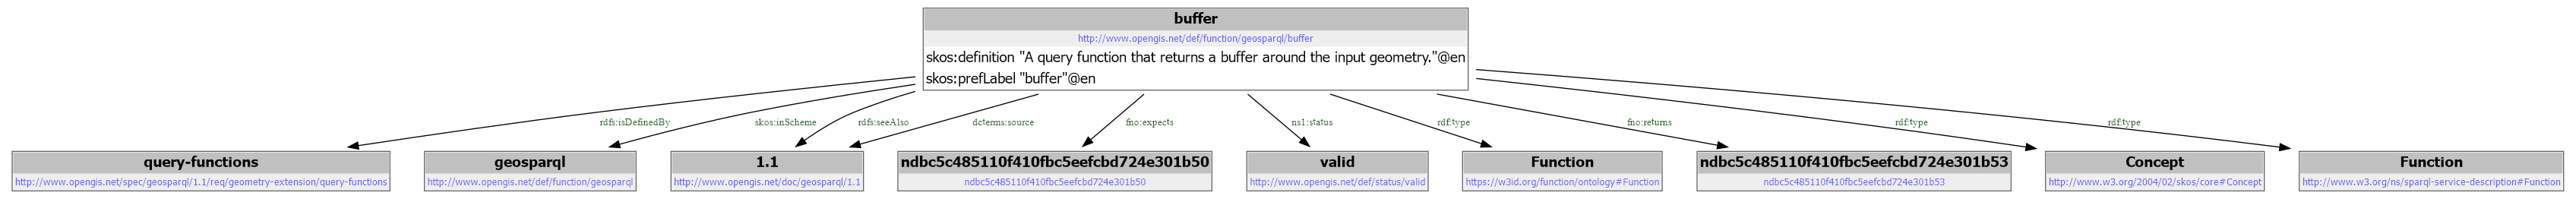

In [15]:
functions = Graph()
functions.parse("ontology/functions_original.ttl")

subject_uri = URIRef("http://www.opengis.net/def/function/geosparql/buffer")

filtered_graph = Graph()
for s, p, o in functions.triples((subject_uri, None, None)):
    filtered_graph.add((s, p, o))

filtered_graph.bind("fno", "https://w3id.org/function/ontology#")
filtered_graph.bind("geof", "http://www.opengis.net/def/function/geosparql/")

print(filtered_graph.serialize(format="turtle"))
def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))

visualize(filtered_graph)

The function still has lots of relations that will not be needed by the LLM to understand the function. Important relations are `rdf:type`, `skos:definition`, `skos:prefLabel`, `fno:expects` and `fno:returns`. Only these should be kept.

In [17]:
filtered_graph = Graph()
filtered_graph.bind("fno", "https://w3id.org/function/ontology#")


allowed_relations = [
    "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",
    "http://www.w3.org/2004/02/skos/core#definition",
    "http://www.w3.org/2004/02/skos/core#prefLabel",
    "https://w3id.org/function/ontology#expects",
    "https://w3id.org/function/ontology#returns"
]

geof = "http://www.opengis.net/def/function/geosparql/"
fnames = ["buffer", "sfContains", "sfCrosses", "sfDisjoint", "sfEquals", "sfIntersects",\
          "sfOverlaps", "sfTouches", "sfWithin", "distance", "envelope"]

allowed_subjects = [geof+f for f in fnames]


for s, p, o in functions.triples((None, None, None)):
    if str(p) in allowed_relations and str(s) in allowed_subjects[:1]:
        filtered_graph.add((s, p, o))


print(filtered_graph.serialize(format="ttl"))

@prefix fno: <https://w3id.org/function/ontology#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

<http://www.opengis.net/def/function/geosparql/buffer> a skos:Concept,
        <http://www.w3.org/ns/sparql-service-description#Function>,
        fno:Function ;
    skos:definition "A query function that returns a buffer around the input geometry."@en ;
    skos:prefLabel "buffer"@en ;
    fno:expects [ ] ;
    fno:returns [ ] .




# Handling blank nodes
When accessing the original graph, the blank-nodes can be made visible by accessing the list:

In [19]:
query = """
PREFIX geof: <http://www.opengis.net/def/function/geosparql/>
PREFIX fno: <https://w3id.org/function/ontology#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?item WHERE {
  geof:buffer fno:expects/rdf:rest*/rdf:first ?item .
}
"""

# Execute the query
results = functions.query(query)

# Print out the items
print("Items in the RDF list:")
for row in results:
    print(row["item"])


Items in the RDF list:
http://www.opengis.net/def/function/geosparql/buffer_param1
http://www.opengis.net/def/function/geosparql/buffer_param2
http://www.opengis.net/def/function/geosparql/buffer_param3


However, when serializing the graph again, this information is lost. Furthermore the LLM will probably have trouble connecting the parameters with correct function. The following workaround will be used: Instead of creating a whole node for each parameter the object for `geof:buffer fno:expects ?object` will just be a literal containing the datatypes for each input/output as a string.

In [21]:
for s, p, o in filtered_graph.triples((None, None, None)):
    if str(p) in ["https://w3id.org/function/ontology#expects", "https://w3id.org/function/ontology#returns"]:
        filtered_graph.remove((s, p, o))

_ = filtered_graph.add((URIRef(geof+"buffer"), URIRef("https://w3id.org/function/ontology#expects"), Literal("(geo:wktLiteral, xsd:double)")))

In [22]:
print(filtered_graph.serialize(format="ttl"))

@prefix fno: <https://w3id.org/function/ontology#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

<http://www.opengis.net/def/function/geosparql/buffer> a skos:Concept,
        <http://www.w3.org/ns/sparql-service-description#Function>,
        fno:Function ;
    skos:definition "A query function that returns a buffer around the input geometry."@en ;
    skos:prefLabel "buffer"@en ;
    fno:expects "(geo:wktLiteral, xsd:double)" .




## For all Functions
Load all the functions needed for the study and adjust their triples.

In [24]:
filtered_graph = Graph()

filtered_graph.bind("fno", "https://w3id.org/function/ontology#")
filtered_graph.bind("geof", "http://www.opengis.net/def/function/geosparql/")
filtered_graph.bind("geo", "http://www.opengis.net/ont/geosparql#")

allowed_relations = [
    "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",
    "http://www.w3.org/2004/02/skos/core#definition",
    "http://www.w3.org/2004/02/skos/core#prefLabel"
]

geof = "http://www.opengis.net/def/function/geosparql/"

allowed_subjects = [geof+f for f in fnames]

for s, p, o in functions.triples((None, None, None)):
    if str(p) in allowed_relations and str(s) in allowed_subjects:
        filtered_graph.add((s, p, o))

for s, p, o in filtered_graph.triples((None, None, None)):
    if str(s) in allowed_subjects:
        if str(p) == "http://www.w3.org/1999/02/22-rdf-syntax-ns#type":
            if str(o) == "http://www.w3.org/ns/sparql-service-description#Function" or str(o) == "http://www.w3.org/2004/02/skos/core#Concept":
                filtered_graph.remove((s, p, o))

fnames = {'buffer': ('(geo:wktLiteral xsd:double)', '(geo:wktLiteral)', 'geof:buffer(?wkt, 1000)'),
 'sfContains': ('(geo:wktLiteral geo:wktLiteral)', '(xsd:boolean)', 'geof:sfContains(?wkt, ?wkt2)'),
 'sfCrosses':  ('(geo:wktLiteral geo:wktLiteral)', '(xsd:boolean)', 'geof:sfCrosses(?wkt, ?wkt2)'),
 'sfDisjoint':  ('(geo:wktLiteral geo:wktLiteral)', '(xsd:boolean)', 'geof:sfDisjoint(?wkt, ?wkt2)'),
 'sfEquals':  ('(geo:wktLiteral geo:wktLiteral)', '(xsd:boolean)', 'geof:sfEquals(?wkt, ?wkt2)'),
 'sfIntersects': ('(geo:wktLiteral geo:wktLiteral)', '(xsd:boolean)', 'geof:sfIntersects(?wkt, ?wkt2)'),
 'sfOverlaps':  ('(geo:wktLiteral geo:wktLiteral)', '(xsd:boolean)', 'geof:sfOverlaps(?wkt, ?wkt2)'),
 'sfTouches':  ('(geo:wktLiteral geo:wktLiteral)', '(xsd:boolean)', 'geof:sfTouches(?wkt, ?wkt2)'),
 'sfWithin':  ('(geo:wktLiteral geo:wktLiteral)', '(xsd:boolean)', 'geof:sfWithin(?wkt, ?wkt2)'),
 'distance':  ('(geo:wktLiteral geo:wktLiteral)', '(xsd:double)', 'geof:distance(?wkt, ?wkt2)'),
 'envelope':  ('(geo:wktLiteral)', '(geo:wktLiteral)', 'geof:envelope(?wkt)')}

fnames_with_geof = {geof + key: value for key, value in fnames.items()}

geof = rdflib.Namespace(geof)
fno = rdflib.Namespace("https://w3id.org/function/ontology#")

## Add triples for better LLM understanding
When using the ontology like this, LLMs still get confused and use `geo:Geometry` instances as a inputs for the functions instead of `geo:wktLiterl` literals. Further clarification is needed.

In [26]:
for key, value in fnames.items():
    subject = geof[key]
    predicate1 = fno["expects"]
    predicate2 = fno["returns"]
    predicate3 = URIRef("http://www.w3.org/2004/02/skos/core#example")
    predicate4 = URIRef("http://www.w3.org/2004/02/skos/core#note")
    object1 = rdflib.Literal(value[0])
    object2 = rdflib.Literal(value[1])
    object3 = rdflib.Literal(f"Example usage of a SPARQL query: {value[2]}")
    object4 = rdflib.Literal(f"When a function expects a geo:wktLiteral it must be a geo:wktLiteral, a geo:Geometry object will not work.")
    
    filtered_graph.add((subject, predicate1, object1))
    filtered_graph.add((subject, predicate2, object2))
    filtered_graph.add((subject, predicate3, object3))
    filtered_graph.add((subject, predicate4, object4))

# print(filtered_graph.serialize(format="ttl"))

For every function, a short usage example and a note is added, highlighting the need for `geo:wktLiterals`.

In [28]:
subject = URIRef("http://www.opengis.net/ont/geosparql#Geometry")
predicate = URIRef("http://www.w3.org/2004/02/skos/core#note")
ontology.remove((subject, predicate, None))
ontology.add((subject, predicate, Literal("Geometries should be represented using the geo:wktLiteral when using geof:Functions")))
#print(ontology.serialize(format="ttl"))

<Graph identifier=N5f2a317ab97147d7b8f4c85c3b7ca4b4 (<class 'rdflib.graph.Graph'>)>

Furthermore, a `skos:note` is added for the `geo:Geometry` class reminding of the correct usage.

In [30]:
ontology_full = ontology + filtered_graph
# print(ontology_full.serialize(format="ttl"))

# Reduce the Ontology
In order to maximise the understandability of the ontology, it is necesarry to remove everything that is not directly needed. For example the relation `rdfs:isDefinedBy` is surely important, however it is not necesarry for generating queries about spatial relations.

While designing the ontology in Protégé, most of these relations were already removed. However, some relations are exported by Protégé that will also not be necessary for the LLM:
- All `rdf:type owl:annotationProperty` objects. These are of course important, however they do not have to be explicitly defined. Further, advanced LLMs should have a general understanding of these properties anyway.


In [32]:
annotation_property_uri = OWL.AnnotationProperty

# Find all subjects that are of type owl:AnnotationProperty
subjects_to_remove = set()
for s, p, o in ontology_full.triples((None, RDF.type, annotation_property_uri)):
    subjects_to_remove.add(s)

triples_to_remove = []
for s in subjects_to_remove:
    for triple in ontology_full.triples((s, None, None)):
        triples_to_remove.append(triple)

for triple in triples_to_remove:
    ontology_full.remove(triple)

# Add cardinal direction functions to ontology
Instead of using one functions that gives alle the cardinal directions there will be four functions for each direction.

In [34]:
statements = [    
    """geof:isNorthOf a fno:Function ;
        skos:definition "A function that identifies if one geographic object is north of another geographic object."@en ;
        skos:example "Example usage in a SPARQL query: geof:isNorthOf(?wkt, ?wkt2)" ;
        skos:prefLabel "is north of"@en ;
        fno:expects "(geo:wktLiteral geo:wktLiteral)" ;
        fno:returns "(xsd:boolean)" .""",
    
    """geof:isWestOf a fno:Function ;
        skos:definition "A function that identifies if one geographic object is west of another geographic object."@en ;
        skos:example "Example usage in a SPARQL query: geof:isWestOf(?wkt, ?wkt2)" ;
        skos:prefLabel "is west of"@en ;
        fno:expects "(geo:wktLiteral geo:wktLiteral)" ;
        fno:returns "(xsd:boolean)" .""",
    
    """geof:isEastOf a fno:Function ;
        skos:definition "A function that identifies if one geographic object is east of another geographic object."@en ;
        skos:example "Example usage in a SPARQL query: geof:isEastOf(?wkt, ?wkt2)" ;
        skos:prefLabel "is east of"@en ;
        fno:expects "(geo:wktLiteral geo:wktLiteral)" ;
        fno:returns "(xsd:boolean)" .""",
    
    """geof:isSouthOf a fno:Function ;
        skos:definition "A function that identifies if one geographic object is south of another geographic object."@en ;
        skos:example "Example usage in a SPARQL query: geof:isSouthOf(?wkt, ?wkt2)" ;
        skos:prefLabel "is south of"@en ;
        fno:expects "(geo:wktLiteral geo:wktLiteral)" ;
        fno:returns "(xsd:boolean)" ."""
]

In [35]:
insert_query = """
PREFIX geof: <http://www.opengis.net/def/function/geosparql/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX fno: <https://w3id.org/function/ontology#>

INSERT DATA {
STATEMENT
}
"""

In [36]:
for statement in statements:
    ontology_full.update(insert_query.replace("STATEMENT", statement))

# Filter the full ontology for only relevant triples
via the predicate.

In [38]:
allowed_relations2 = [
    "http://www.w3.org/2000/01/rdf-schema#domain",
    "http://www.w3.org/2004/02/skos/core#prefLabel",
    "https://w3id.org/function/ontology#expects",
    "http://www.w3.org/2004/02/skos/core#example",
    "http://www.w3.org/2000/01/rdf-schema#label",
    "http://www.w3.org/2000/01/rdf-schema#comment",
    "https://w3id.org/function/ontology#returns",
    "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",
    "http://www.w3.org/2000/01/rdf-schema#subClassOf",
    "http://www.w3.org/2000/01/rdf-schema#range",
    "http://www.w3.org/2004/02/skos/core#note",
    "http://www.w3.org/2004/02/skos/core#definition",
    "http://www.w3.org/2002/07/owl#equivalentClass"]

filtered_ontology = Graph()

filtered_ontology.bind("fno", "https://w3id.org/function/ontology#")
filtered_ontology.bind("geof", "http://www.opengis.net/def/function/geosparql/")
filtered_ontology.bind("gn", "https://www.geonames.org/ontology#")
filtered_ontology.bind("gn", "https://www.geonames.org/ontology#")
filtered_ontology.bind("nutsdef", "http://data.europa.eu/nuts/")

for s, p, o in ontology_full.triples((None, None, None)):
    if str(p) in allowed_relations2:
        filtered_ontology.add((s, p, o))

# print(filtered_ontology.serialize(format="ttl"))

In [39]:
# used in the first set of experiments
ontology_full_turtle = ontology_full.serialize(format="turtle")
ontology_full.serialize(destination="data/ontology_full_v1.ttl", format="turtle")

<Graph identifier=N7e33c6c623ce428292a2bfa517a9874c (<class 'rdflib.graph.Graph'>)>

In [40]:
# not used yet
filtered_ontology_turtle = filtered_ontology.serialize(format="turtle")
filtered_ontology.serialize(destination="data/ontology_full_v2.ttl", format="turtle")

# visualize(ontology_full)
# print(ontology_full_turtle)

<Graph identifier=N2916b74c92924de8acd2280129299a9b (<class 'rdflib.graph.Graph'>)>

# Get alternative Ontology
To test the raw reasoning capabilities, all explanations (natural language) triples are removed. If the LLM does have reasoning capabilities beyond just natural language, this should not make a difference.

In [42]:
allowed_relations2 = [
    "http://www.w3.org/2000/01/rdf-schema#domain",
    "http://www.w3.org/2004/02/skos/core#prefLabel",
    "https://w3id.org/function/ontology#expects",
    "http://www.w3.org/2000/01/rdf-schema#label",
    "https://w3id.org/function/ontology#returns",
    "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",
    "http://www.w3.org/2000/01/rdf-schema#subClassOf",
    "http://www.w3.org/2000/01/rdf-schema#range",
    "http://www.w3.org/2002/07/owl#equivalentClass"]

filtered_ontology = Graph()

filtered_ontology.bind("fno", "https://w3id.org/function/ontology#")
filtered_ontology.bind("geof", "http://www.opengis.net/def/function/geosparql/")
filtered_ontology.bind("gn", "https://www.geonames.org/ontology#")
filtered_ontology.bind("gn", "https://www.geonames.org/ontology#")
filtered_ontology.bind("nutsdef", "http://data.europa.eu/nuts/")

for s, p, o in ontology_full.triples((None, None, None)):
    if str(p) in allowed_relations2:
        filtered_ontology.add((s, p, o))

filtered_ontology_turtle = filtered_ontology.serialize(format="turtle")
filtered_ontology.serialize(destination="data/ontology_full_v3.ttl", format="turtle")


<Graph identifier=Na4e0ac7830e444fe846b28eaa4b52596 (<class 'rdflib.graph.Graph'>)>